In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/'
normal_images_dir = os.path.join(base_dir, 'normal')
ghibli_images_dir = os.path.join(base_dir, 'ghibli')

print(f"Path to normal images folder: {normal_images_dir}")
print(f"Path to Ghibli images folder: {ghibli_images_dir}")

Mounted at /content/drive
Path to normal images folder: /content/drive/MyDrive/normal
Path to Ghibli images folder: /content/drive/MyDrive/ghibli


In [1]:
import os
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from PIL import Image

import skimage.io
import skimage.feature
import skimage.transform

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# DL models

In [3]:
# Define image size
IMG_SIZE = 224

def load_and_preprocess_data(normal_dir, ghibli_dir, img_size=(IMG_SIZE, IMG_SIZE)):
    """Loads images from directories, preprocesses them, and creates labels."""
    images = []
    labels = []

    for filename in os.listdir(normal_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                img_path = os.path.join(normal_dir, filename)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img)
                img_array = img_array / 255.0  # Normalize pixel values
                images.append(img_array)
                labels.append(0)  # Label 0 for normal images
            except Exception as e:
                print(f"Error loading or preprocessing normal image {filename}: {e}")

    for filename in os.listdir(ghibli_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                img_path = os.path.join(ghibli_dir, filename)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img)
                img_array = img_array / 255.0    # Normalize pixel values
                images.append(img_array)
                labels.append(1)                 # Label 1 for Ghibli images
            except Exception as e:
                print(f"Error loading or preprocessing Ghibli image {filename}: {e}")

    return np.array(images), np.array(labels)

def train_model(model, train_data, train_labels, val_data, val_labels, epochs=10, batch_size=32):
    """Trains the model using data augmentation."""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(train_data)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
                  metrics=['accuracy'])

    history = model.fit(
        datagen.flow(train_data, train_labels, batch_size=batch_size),
        steps_per_epoch=len(train_data) // batch_size,
        validation_data=(val_data, val_labels),
        epochs=epochs
    )
    return history

def evaluate_model(model, test_data, test_labels):
    """Evaluates the trained model on the test data."""
    loss, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    y_pred_probs = model.predict(test_data)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(test_labels, y_pred, target_names=['Normal', 'Ghibli']))

    cm = confusion_matrix(test_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ghibli'], yticklabels=['Normal', 'Ghibli'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Load and preprocess data
images, labels = load_and_preprocess_data(normal_images_dir, ghibli_images_dir)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Split training data further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Try MobilenetV2

In [ ]:
def build_efficient_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=2):
    """Builds an efficient image classification model using MobileNetV2."""
    input_tensor = Input(shape=input_shape)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

<ipython-input-3-e69ec7e0b155>:38: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 657ms/step - accuracy: 0.7358 - loss: 0.5473 - val_accuracy: 0.8948 - val_loss: 0.2863
Epoch 2/20
 1/45 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8438 - loss: 0.4701

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8438 - loss: 0.4701 - val_accuracy: 0.8928 - val_loss: 0.2840
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 466ms/step - accuracy: 0.9011 - loss: 0.2487 - val_accuracy: 0.8866 - val_loss: 0.2669
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9375 - loss: 0.1764 - val_accuracy: 0.8742 - val_loss: 0.3247
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 434ms/step - accuracy: 0.9204 - loss: 0.2021 - val_accuracy: 0.8887 - val_loss: 0.2730
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9062 - loss: 0.1673 - val_accuracy: 0.9093 - val_loss: 0.2307
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 397ms/step - accuracy: 0.9140 - loss: 0.2082 - val_accuracy: 0.8825 - val_loss: 0.2790
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8750 - loss: 0.3471 - val_accuracy: 0.8454 - val_loss: 0.3528
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step - accuracy: 0.9301 - loss: 0.1805 - val_accuracy: 0.8845 - val_

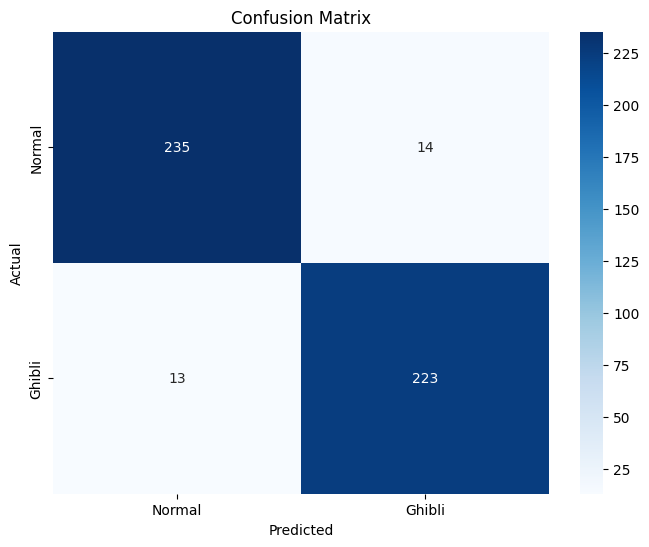

Trained model saved as ghibli_normal_mobilenet.h5


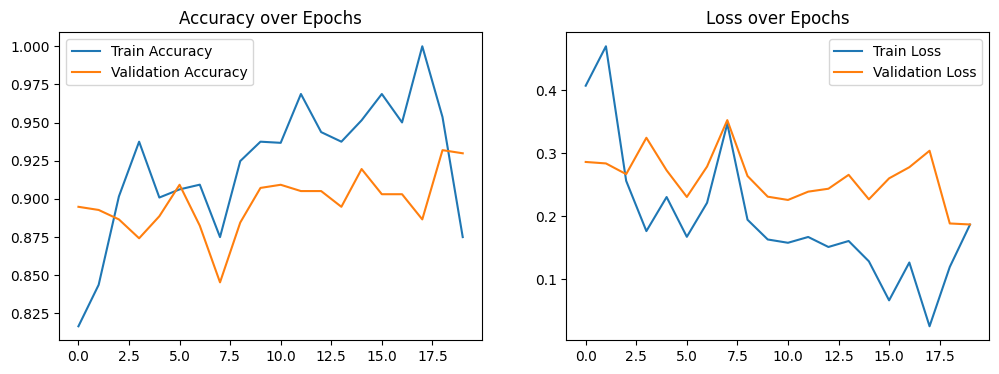

In [6]:
# Build the efficient model
model = build_efficient_model()

# Train the model
history = train_model(model, X_train, y_train, X_val, y_val, epochs=20)

# Evaluate the model
evaluate_model(model, X_test, y_test)

model.save('ghibli_normal_mobilenet.h5')
print("Trained model saved as ghibli_normal_mobilenet.h5")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [ ]:
# Load the trained model
try:
    model = load_model('ghibli_normal_mobilenet.h5')
    print("Trained model loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'ghibli_normal_classifier.h5' was not found. Make sure the model is saved in the same directory or provide the correct path.")
    model = None

In [ ]:
def predict_image(image_path):
    """
    Predicts whether an image is Ghibli or not using the loaded model.

    Args:
        image_path (str): The path to the image file.

    Returns:
        str: "Ghibli" or "Not Ghibli" based on the prediction, or an error message.
    """
    IMG_SIZE = 224
    if model is None:
        return "Model not loaded. Cannot make prediction."

    try:
        img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Create a batch of size 1
        img_array /= 255.0  # Normalize the image

        prediction = model.predict(img_array)

        if prediction[0][1] > 0.5:  # Probability of being Ghibli (index 1)
            return "Ghibli"
        else:
            return "Not Ghibli"

    except FileNotFoundError:
        return f"Error: Image not found at path: {image_path}"
    except Exception as e:
        return f"Error processing image: {e}"

Trained model loaded successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The image '/content/im.png' is predicted as: Not Ghibli


In [ ]:
test_image = '/content/test_00.png'
if model:
    prediction = predict_image(test_image)
    print(f"The image '{test_image}' is predicted as: {prediction}")

# Try ML models

In [12]:
# Define image size for resizing before feature extraction
IMG_SIZE = 128

# Define HOG parameters
HOG_PARAMS = {'orientations': 8,
              'pixels_per_cell': (16, 16),
              'cells_per_block': (1, 1),
              'block_norm': 'L2-Hys'}

def load_and_extract_features(normal_dir, ghibli_dir, img_size=(IMG_SIZE, IMG_SIZE), hog_params=HOG_PARAMS):
    """Loads images, resizes them, and extracts HOG features."""
    features = []
    labels = []

    for label, img_dir in enumerate([normal_dir, ghibli_dir]):
        for filename in os.listdir(img_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(img_dir, filename)
                    img = Image.open(img_path).convert('RGB')  # Ensure RGB
                    img_resized = img.resize(img_size)
                    img_array = np.array(img_resized)

                    hog_features = hog(img_array, feature_vector=True, channel_axis=-1, **hog_params)
                    features.append(hog_features)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing image {filename} from {img_dir}: {e}")

    return np.array(features), np.array(labels)

def train_ml_model(features_train, labels_train, model_type='logistic_regression'):
    """Trains a specified ML model."""
    if model_type == 'logistic_regression':
        model = LogisticRegression(solver='liblinear', random_state=42)
    elif model_type == 'svm':
        model = SVC(kernel='linear', random_state=42)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(n_estimators=200, random_state=42)
    elif model_type == 'xgboost':
        model = xgb.XGBClassifier(random_state=42)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    model.fit(features_train, labels_train)
    return model

def evaluate_ml_model(model, features_test, labels_test, target_names=['Normal', 'Ghibli']):
    """Evaluates the trained ML model."""
    predictions = model.predict(features_test)
    accuracy = accuracy_score(labels_test, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(labels_test, predictions, target_names=target_names))

    cm = confusion_matrix(labels_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def predict_ml_image(image_path, model, img_size=(IMG_SIZE, IMG_SIZE), hog_params=HOG_PARAMS):
    """Predicts whether an image is Ghibli or not using the trained ML model."""
    try:
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize(img_size)
        img_array = np.array(img_resized)
        hog_features = hog(img_array, feature_vector=True, channel_axis=-1, **hog_params)
        hog_features = hog_features.reshape(1, -1)  # Reshape for single prediction
        prediction = model.predict(hog_features)
        return "Ghibli" if prediction[0] == 1 else "Not Ghibli"
    except FileNotFoundError:
        return f"Error: Image not found at path: {image_path}"
    except Exception as e:
        return f"Error processing image: {e}"

In [5]:
# Load and extract features
features, labels = load_and_extract_features(normal_images_dir, ghibli_images_dir)

# Split data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)


Training Logistic Regression model:
Test Accuracy: 0.9934

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       179
      Ghibli       1.00      0.98      0.99       125

    accuracy                           0.99       304
   macro avg       0.99      0.99      0.99       304
weighted avg       0.99      0.99      0.99       304



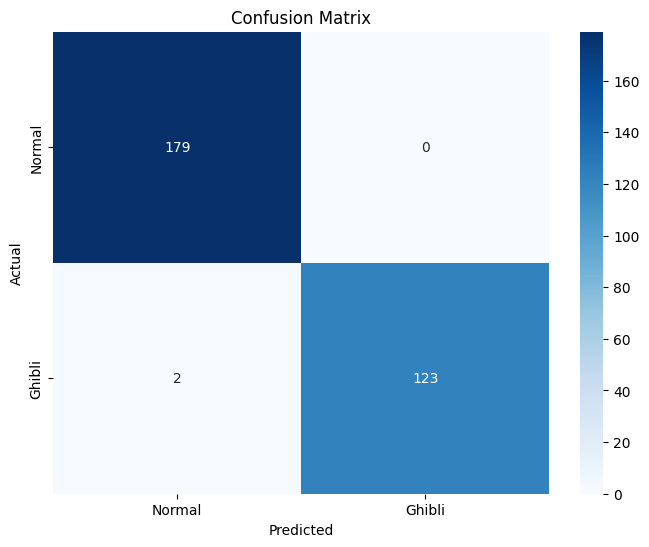


Training SVM model:
Test Accuracy: 0.9967

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       179
      Ghibli       1.00      0.99      1.00       125

    accuracy                           1.00       304
   macro avg       1.00      1.00      1.00       304
weighted avg       1.00      1.00      1.00       304



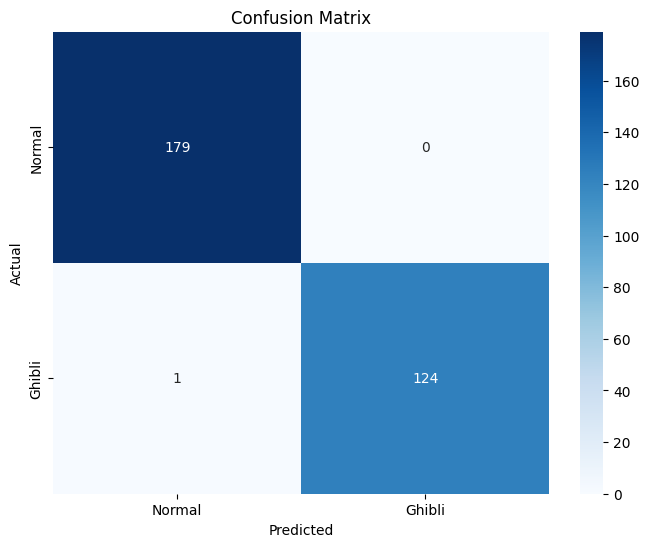


Training Random Forest model:
Test Accuracy: 0.9934

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99       179
      Ghibli       0.98      1.00      0.99       125

    accuracy                           0.99       304
   macro avg       0.99      0.99      0.99       304
weighted avg       0.99      0.99      0.99       304



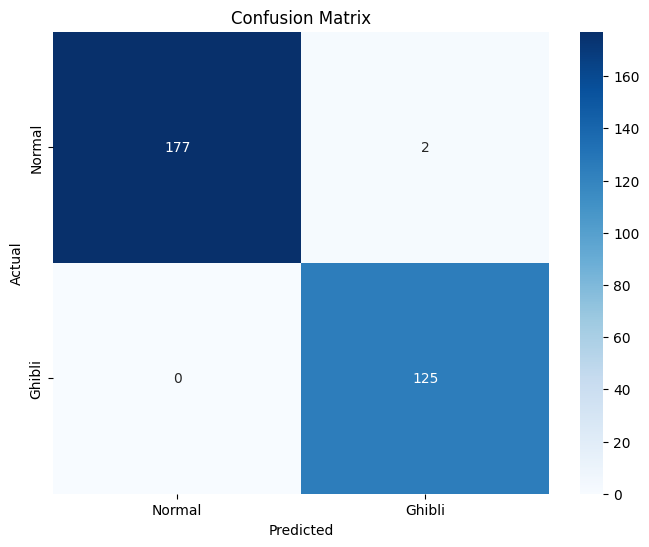


Training XGBoost model:
Test Accuracy: 0.9868

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       179
      Ghibli       0.98      0.99      0.98       125

    accuracy                           0.99       304
   macro avg       0.99      0.99      0.99       304
weighted avg       0.99      0.99      0.99       304



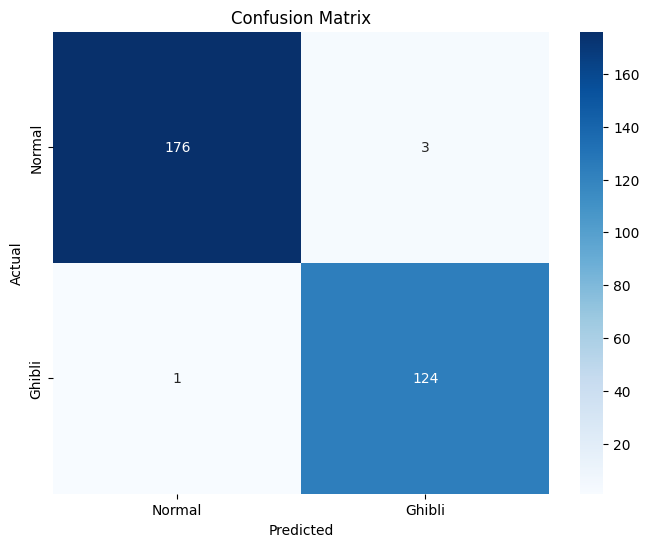

In [6]:
# Train a Logistic Regression model
print("\nTraining Logistic Regression model:")
logistic_regression_model = train_ml_model(features_train, labels_train, model_type='logistic_regression')
evaluate_ml_model(logistic_regression_model, features_test, labels_test)

# Train an SVM model
print("\nTraining SVM model:")
svm_model = train_ml_model(features_train, labels_train, model_type='svm')
evaluate_ml_model(svm_model, features_test, labels_test)

# Train a Random Forest model
print("\nTraining Random Forest model:")
random_forest_model = train_ml_model(features_train, labels_train, model_type='random_forest')
evaluate_ml_model(random_forest_model, features_test, labels_test)

# Train an XGBoost model
print("\nTraining XGBoost model:")
xgboost_model = train_ml_model(features_train, labels_train, model_type='xgboost')
evaluate_ml_model(xgboost_model, features_test, labels_test)

# SVC improvement

In [9]:
# Define image size for resizing before feature extraction
IMG_SIZE = 128

# Define HOG parameters
HOG_PARAMS = {'orientations': 8,
              'pixels_per_cell': (16, 16),
              'cells_per_block': (1, 1),
              'block_norm': 'L2-Hys'}

def load_and_extract_features(normal_dir, ghibli_dir, img_size=(IMG_SIZE, IMG_SIZE), hog_params=HOG_PARAMS):
    """Loads images, resizes them, and extracts HOG features."""
    features = []
    labels = []

    for label, img_dir in enumerate([normal_dir, ghibli_dir]):
        for filename in os.listdir(img_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(img_dir, filename)
                    img = Image.open(img_path).convert('RGB')  # Ensure RGB
                    img_resized = img.resize(img_size)
                    img_array = np.array(img_resized)

                    hog_features = hog(img_array, feature_vector=True, channel_axis=-1, **hog_params)
                    features.append(hog_features)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing image {filename} from {img_dir}: {e}")

    return np.array(features), np.array(labels)

def evaluate_ml_model(model, features_test, labels_test, target_names=['Normal', 'Ghibli']):
    """Evaluates the trained ML model."""
    predictions = model.predict(features_test)
    accuracy = accuracy_score(labels_test, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(labels_test, predictions, target_names=target_names))

    cm = confusion_matrix(labels_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def predict_ml_image(image_path, model, img_size=(IMG_SIZE, IMG_SIZE), hog_params=HOG_PARAMS):
    """Predicts whether an image is Ghibli or not using the trained ML model."""
    try:
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize(img_size)
        img_array = np.array(img_resized)
        hog_features = hog(img_array, feature_vector=True, channel_axis=-1, **hog_params)
        hog_features = hog_features.reshape(1, -1)  # Reshape for single prediction
        prediction = model.predict(hog_features)
        return "Ghibli" if prediction[0] == 1 else "Not Ghibli"
    except FileNotFoundError:
        return f"Error: Image not found at path: {image_path}"
    except Exception as e:
        return f"Error processing image: {e}"

In [10]:
# Load and extract features
features, labels = load_and_extract_features(normal_images_dir, ghibli_images_dir)

# Split data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Scale features
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)


Performing GridSearchCV for Linear and RBF Kernels:
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found: {'C': 0.01, 'kernel': 'linear'}
Best cross-validation score: 0.9992

Evaluating the best SVM model on the test set:
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       179
      Ghibli       1.00      1.00      1.00       125

    accuracy                           1.00       304
   macro avg       1.00      1.00      1.00       304
weighted avg       1.00      1.00      1.00       304



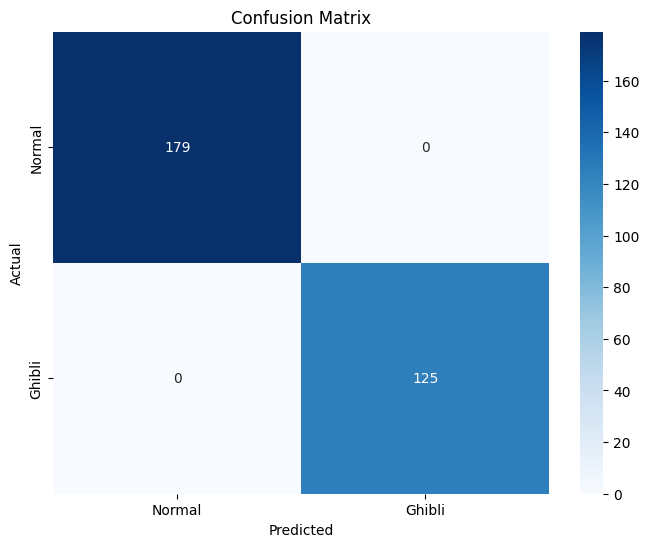


Best SVM model saved as: best_svm_model.pkl


In [13]:
# Define the parameter grid for GridSearchCV including 'kernel'
param_grid = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
]

# Perform GridSearchCV for both Linear and RBF Kernels
print("\nPerforming GridSearchCV for Linear and RBF Kernels:")
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(features_train_scaled, labels_train)

# Print the best parameters and the best score
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best estimator (the model with the best parameters)
best_svm_model = grid_search.best_estimator_

# Evaluate the best model on the test set
print("\nEvaluating the best SVM model on the test set:")
evaluate_ml_model(best_svm_model, features_test_scaled, labels_test)

# Save the best model
model_filename = 'best_svm_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_svm_model, file)
print(f"\nBest SVM model saved as: {model_filename}")

# Example prediction using the best trained SVM model
example_image_path = 'path/to/your/test_image.jpg'  # Replace with the actual path
if os.path.exists(example_image_path):
    prediction = predict_ml_image(example_image_path, best_svm_model)
    print(f"\nImage '{example_image_path}' predicted as: {prediction} (using the best SVM model)")

In [14]:
# Load the saved model for prediction
loaded_model = None
try:
    with open(model_filename, 'rb') as file:
        loaded_model = pickle.load(file)
    print(f"\nLoaded the saved model from: {model_filename}")
except FileNotFoundError:
    print(f"\nError: Could not find the saved model file: {model_filename}")
except Exception as e:
    print(f"\nError loading the saved model: {e}")


Loaded the saved model from: best_svm_model.pkl


In [17]:
example_image_path = '/content/ghibli-content-imgs1.png'
if os.path.exists(example_image_path) and loaded_model:
    prediction = predict_ml_image(example_image_path, loaded_model)
    print(f"\nImage '{example_image_path}' predicted as: {prediction} (using the loaded SVM model)")


Image '/content/ghibli-content-imgs1.png' predicted as: Not Ghibli (using the loaded SVM model)
